# LSTM Multivariate Time Series Forecasting

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow.keras.models as tkm
import tensorflow.keras.layers as tkl
import tensorflow.keras.utils as tku
import tensorflow.keras.backend as tkb
import tensorflow.keras.callbacks as tkc
import tensorflow.keras.preprocessing as tkp
import tensorflow.keras.optimizers as tko
import tensorflow_addons as tfa

from datetime import datetime
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from mlfs.utils.LSTM import *

### Load data

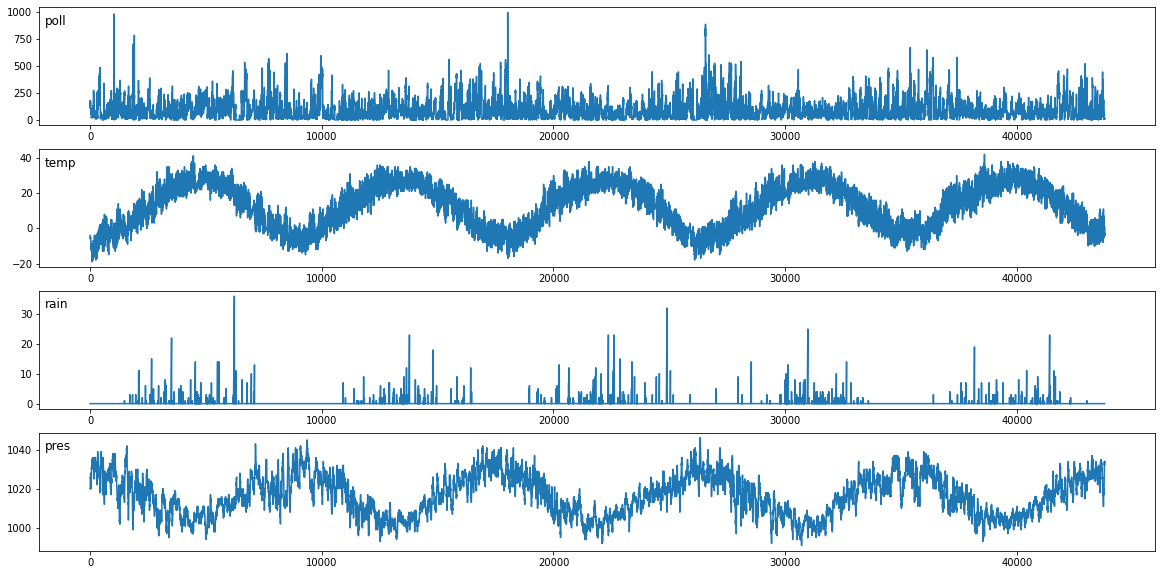

In [8]:
data = pd.read_csv('D:/data/csv/pollution.csv', header=0, index_col=0)
df = data[['pollution', 'temp', 'rain', 'press']]
df.columns = ['poll', 'temp', 'rain', 'pres']
show_tss(df)

### Model

In [9]:
def get_model(X_train):
    model = tkm.Sequential()
    model.add(tkl.LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(tkl.Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

def fit_model(model, X_train, y_train, X_test, y_test, verbose=0):
    history = model.fit(X_train, y_train, epochs=10, batch_size=72, validation_data=(X_test, y_test), verbose=verbose, shuffle=False)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
def predict(model, X_test, y_test, rows):
    pred = model.predict(X_test)
    res = pd.DataFrame(y_test[:,0], columns=['real'])
    res['pred'] = np.round(pred)
    return res.head(rows)

### Univariate, one step forecast

In [10]:
nvars=1
nsteps=1
mw=6
ds = build_ds(df, vobs=['poll'], mw=mw, fh=nsteps)
X_train, y_train, X_test, y_test  = prep_train(ds, split_index=365*24, nvars=nvars, nsteps=nsteps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train, X_test = reshape4lstm(X_train, X_test, mw)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(8760, 6) (8760, 1) (35034, 6) (35034, 1)


((8760, 6, 1), (8760, 1), (35034, 6, 1), (35034, 1))

In [12]:
ds.head()

,poll(t-6),poll(t-5),poll(t-4),poll(t-3),poll(t-2),poll(t-1),poll(t)
date,,,,,,,
2010-01-02 06:00:00,129.0,148.0,159.0,181.0,138.0,109.0,105.0
2010-01-02 07:00:00,148.0,159.0,181.0,138.0,109.0,105.0,124.0
2010-01-02 08:00:00,159.0,181.0,138.0,109.0,105.0,124.0,120.0
2010-01-02 09:00:00,181.0,138.0,109.0,105.0,124.0,120.0,132.0
2010-01-02 10:00:00,138.0,109.0,105.0,124.0,120.0,132.0,140.0


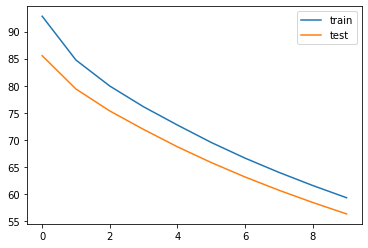

,real,pred
0,14.0,17.0
1,14.0,15.0
2,22.0,15.0
3,22.0,21.0
4,25.0,21.0


In [13]:
model = get_model(X_train)
fit_model(model, X_train, y_train, X_test, y_test)
predict(model, X_test, y_test, 5)

### Univariate, 3 step forecast

In [17]:
nvars=1
nsteps=3
mw=6
ds = build_ds(df, vobs=['poll'], mw=mw, fh=nsteps)
print(ds.shape, ds.size)
ds.head()

(43792, 9) 394128


,poll(t-6),poll(t-5),poll(t-4),poll(t-3),poll(t-2),poll(t-1),poll(t),poll(t+1),poll(t+2)
date,,,,,,,,,
2010-01-02 06:00:00,129.0,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0
2010-01-02 07:00:00,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0
2010-01-02 08:00:00,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0
2010-01-02 09:00:00,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0
2010-01-02 10:00:00,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0


In [15]:
X_train, y_train, X_test, y_test  = prep_train(ds, split_index=365*24, nvars=nvars, nsteps=nsteps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train, X_test = reshape4lstm(X_train, X_test, mw)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(8760, 100) (8760, 28) (34913, 100) (34913, 28)


((8760, 100, 1), (8760, 28), (34913, 100, 1), (34913, 28))

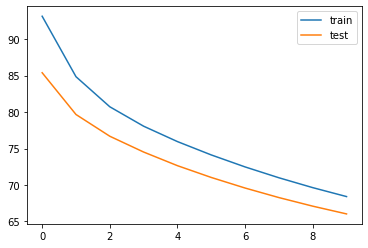

,real,pred
0,13.0,23.0
1,13.0,24.0
2,9.0,24.0
3,6.0,20.0
4,9.0,17.0


In [16]:
model = get_model(X_train)
fit_model(model, X_train, y_train, X_test, y_test)
predict(model, X_test, y_test, 5)

### Bivariate, one step forecast

In [10]:
nvars=2
nsteps=1
mw=6
ds = build_ds(df, vobs=['poll', 'temp'], mw=mw, fh=nsteps)
print(ds.shape, ds.size)
ds.head()

(43794, 14) 613116


,poll(t-6),temp(t-6),poll(t-5),temp(t-5),poll(t-4),temp(t-4),poll(t-3),temp(t-3),poll(t-2),temp(t-2),poll(t-1),temp(t-1),poll(t),temp(t)
date,,,,,,,,,,,,,,
2010-01-02 06:00:00,129.0,-4.0,148.0,-4.0,159.0,-5.0,181.0,-5.0,138.0,-5.0,109.0,-6.0,105.0,-6.0
2010-01-02 07:00:00,148.0,-4.0,159.0,-5.0,181.0,-5.0,138.0,-5.0,109.0,-6.0,105.0,-6.0,124.0,-5.0
2010-01-02 08:00:00,159.0,-5.0,181.0,-5.0,138.0,-5.0,109.0,-6.0,105.0,-6.0,124.0,-5.0,120.0,-6.0
2010-01-02 09:00:00,181.0,-5.0,138.0,-5.0,109.0,-6.0,105.0,-6.0,124.0,-5.0,120.0,-6.0,132.0,-5.0
2010-01-02 10:00:00,138.0,-5.0,109.0,-6.0,105.0,-6.0,124.0,-5.0,120.0,-6.0,132.0,-5.0,140.0,-5.0


In [12]:
X_train, y_train, X_test, y_test  = prep_train(ds, split_index=365*24, nvars=nvars, nsteps=nsteps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train, X_test = reshape4lstm(X_train, X_test, mw)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(8760, 12) (8760, 2) (35034, 12) (35034, 2)


((8760, 6, 2), (8760, 2), (35034, 6, 2), (35034, 2))

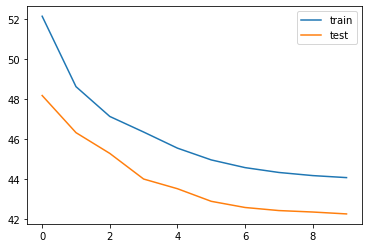

,real,pred
0,14.0,-0.0
1,14.0,-1.0
2,22.0,-1.0
3,22.0,-0.0
4,25.0,0.0


In [13]:
model = get_model(X_train)
fit_model(model, X_train, y_train, X_test, y_test)
predict(model, X_test, y_test, 5)

### Multivariate two steps forecast

In [14]:
nvars=3
nsteps=2
mw=6
ds = build_ds(df, vobs=['poll', 'temp', 'rain'], mw=mw, fh=nsteps)
print(ds.shape, ds.size)
ds.head()

(43793, 24) 1051032


,poll(t-6),temp(t-6),rain(t-6),poll(t-5),temp(t-5),rain(t-5),poll(t-4),temp(t-4),rain(t-4),poll(t-3),...,rain(t-2),poll(t-1),temp(t-1),rain(t-1),poll(t),temp(t),rain(t),poll(t+1),temp(t+1),rain(t+1)
date,,,,,,,,,,,,,,,,,,,,,
2010-01-02 06:00:00,129.0,-4.0,0.0,148.0,-4.0,0.0,159.0,-5.0,0.0,181.0,...,0.0,109.0,-6.0,0.0,105.0,-6.0,0,124.0,-5.0,0.0
2010-01-02 07:00:00,148.0,-4.0,0.0,159.0,-5.0,0.0,181.0,-5.0,0.0,138.0,...,0.0,105.0,-6.0,0.0,124.0,-5.0,0,120.0,-6.0,0.0
2010-01-02 08:00:00,159.0,-5.0,0.0,181.0,-5.0,0.0,138.0,-5.0,0.0,109.0,...,0.0,124.0,-5.0,0.0,120.0,-6.0,0,132.0,-5.0,0.0
2010-01-02 09:00:00,181.0,-5.0,0.0,138.0,-5.0,0.0,109.0,-6.0,0.0,105.0,...,0.0,120.0,-6.0,0.0,132.0,-5.0,0,140.0,-5.0,0.0
2010-01-02 10:00:00,138.0,-5.0,0.0,109.0,-6.0,0.0,105.0,-6.0,0.0,124.0,...,0.0,132.0,-5.0,0.0,140.0,-5.0,0,152.0,-5.0,0.0


In [15]:
X_train, y_train, X_test, y_test  = prep_train(ds, split_index=365*24, nvars=nvars, nsteps=nsteps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train, X_test = reshape4lstm(X_train, X_test, mw)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(8760, 18) (8760, 6) (35033, 18) (35033, 6)


((8760, 6, 3), (8760, 6), (35033, 6, 3), (35033, 6))

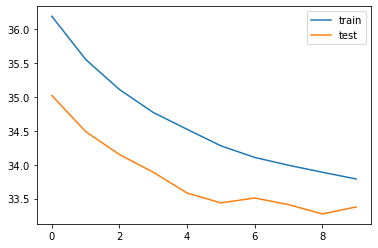

,real,pred
0,14.0,0.0
1,14.0,0.0
2,22.0,0.0
3,22.0,0.0
4,25.0,0.0


In [16]:
model = get_model(X_train)
fit_model(model, X_train, y_train, X_test, y_test)
predict(model, X_test, y_test, 5)